### Setting Up the Environment

In this section, we will set up the environment by mounting Google Drive to access our project files and importing the necessary libraries.


In [ ]:
# Mount Google Drive
!git clone https://github.com/tmagcaya/MotionPPGNet.git
%ls

# Import necessary libraries
import glob
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import time
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Import model libraries
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, Flatten, MaxPooling1D, BatchNormalization, LSTM
from keras import optimizers
from keras.utils import to_categorical
from keras.models import load_model

# Define constants
fs = 125
minBPM = 40
maxBPM = 240
window_length = 8 * fs
window_shift = 2 * fs
# Define the file path to save or load the model
model_path = 'MotionPPGNet/pretrained/' + 'saved_model.h5'
# Flag to indicate whether to train the model or load an existing one
train_model = True

fatal: destination path 'MotionPPGNet' already exists and is not an empty directory.
MotionPPGNet/  MotionPPGNet11/  sample_data/


### Load and Explore the Troika Dataset

We will load the Troika dataset, which consists of PPG and accelerometer data. Let's start by retrieving the filenames and exploring the data structure.


In [ ]:
# Function to load dataset
def LoadTroikaDataset():
    data_dir = "MotionPPGNet/datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

# Retrieve dataset files
data_fls, ref_fls = LoadTroikaDataset()
print("Data files:", data_fls)
print("Reference files:", ref_fls)

# Load and explore a sample data file
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
print("PPG shape:", ppg.shape)
print("AccX shape:", accx.shape)
print("AccY shape:", accy.shape)
print("AccZ shape:", accz.shape)

Data files: ['MotionPPGNet/datasets/troika/training_data/DATA_01_TYPE01.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_02_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_03_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_04_TYPE01.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_04_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_05_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_06_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_07_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_08_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_10_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_11_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/DATA_12_TYPE02.mat']
Reference files: ['MotionPPGNet/datasets/troika/training_data/REF_01_TYPE01.mat', 'MotionPPGNet/datasets/troika/training_data/REF_02_TYPE02.mat', 'MotionPPGNet/datasets/troika/training_data/REF_03_TYPE02.mat

### Load and Explore the Troika Dataset

We will load the Troika dataset, which consists of PPG and accelerometer data. Let's start by retrieving the filenames and exploring the data structure.


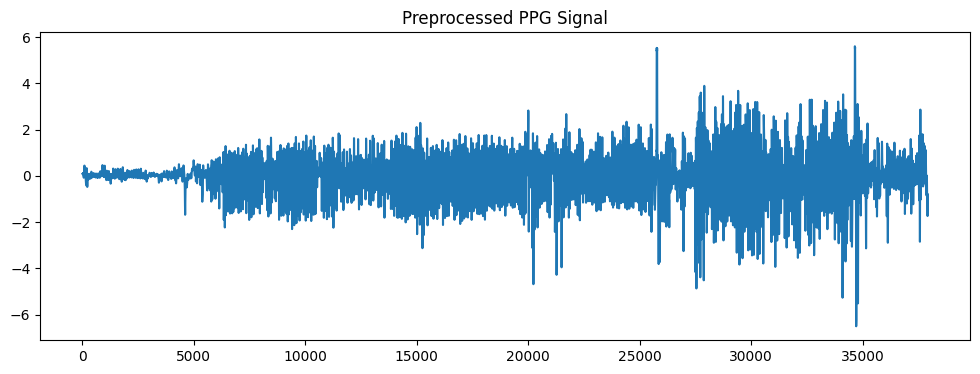

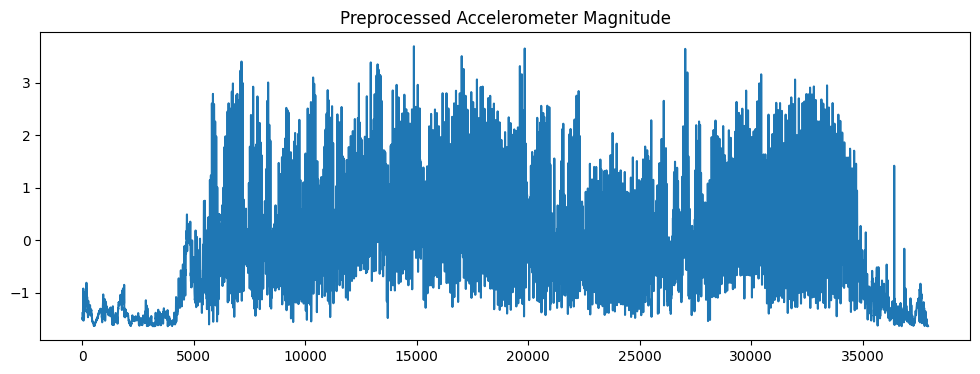

In [ ]:
def bandpass_filter(signal, fs=125, order=4, window=[6/60, 1080/60]):
    b, a = scipy.signal.butter(order, window, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)

def calculate_magnitude(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

# Apply bandpass filter
fs = 125
ppg = bandpass_filter(ppg, fs)
accx = bandpass_filter(accx, fs)
accy = bandpass_filter(accy, fs)
accz = bandpass_filter(accz, fs)

# Calculate magnitude of acceleration
acc = calculate_magnitude(accx, accy, accz)

# Standardize signals
ppg = (ppg - np.mean(ppg)) / np.std(ppg)
acc = (acc - np.mean(acc)) / np.std(acc)

# Plot the preprocessed signals
plt.figure(figsize=(12, 4))
plt.plot(ppg)
plt.title('Preprocessed PPG Signal')
plt.figure(figsize=(12, 4))
plt.plot(acc)
plt.title('Preprocessed Accelerometer Magnitude')
plt.show()

In [ ]:
# prompt: I have two series datasets, PPG and IMU.  GIve me an interactive UI that I can use to slide 10s segments in the dataset and show the spectral component on the side. PPG data is in variable ppg and IMU data is in variable acc

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Define a function to plot the PPG and IMU data
def plot_data(ppg_start, ppg_end, imu_start, imu_end):
    # Extract the PPG and IMU data segments
    ppg_segment = ppg[ppg_start:ppg_end]
    imu_segment = acc[imu_start:imu_end]

    # Plot the PPG data
    plt.figure(figsize=(12, 4))
    plt.plot(ppg_segment)
    plt.title('PPG Signal')

    # Plot the IMU data
    plt.figure(figsize=(12, 4))
    plt.plot(imu_segment)
    plt.title('IMU Signal')

    # Calculate and plot the spectral components
    # (This part is not implemented in the provided code)
    # ...

    # Display the plots
    plt.show()

# Create sliders for PPG and IMU data segments
ppg_start_slider = widgets.IntSlider(min=0, max=len(ppg)-window_length, step=window_shift, value=0)
ppg_end_slider = widgets.IntSlider(min=window_length, max=len(ppg), step=window_shift, value=window_length)
imu_start_slider = widgets.IntSlider(min=0, max=len(acc)-window_length, step=window_shift, value=0)
imu_end_slider = widgets.IntSlider(min=window_length, max=len(acc), step=window_shift, value=window_length)

# Link the sliders to the plot function
interact(plot_data, ppg_start=ppg_start_slider, ppg_end=ppg_end_slider, imu_start=imu_start_slider, imu_end=imu_end_slider);


interactive(children=(IntSlider(value=0, description='ppg_start', max=36937, step=250), IntSlider(value=1000, …

### Prepare Data for Training

We will prepare the data for training by creating windows of PPG and accelerometer signals. We will also load the ground truth reference data for training and evaluation.


Shape of X1: (148, 1000)
Shape of y1: (148,)


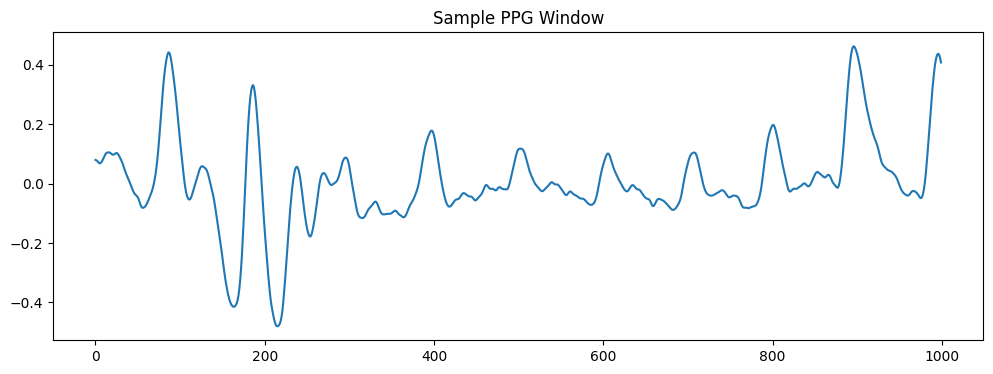

In [ ]:
# Load ground truth reference data
ground_truth = sp.io.loadmat(ref_fls[0])['BPM0'].reshape(-1)

# Define window length and shift
window_length = 8 * fs
window_shift = 2 * fs

# Create windows of PPG and accelerometer signals
X1 = []
y1 = ground_truth
for i in range(0, len(ppg) - window_length + 1, window_shift):
    ppg_window = ppg[i:i+window_length]
    acc_window = acc[i:i+window_length]
    X1.append(ppg_window)

X1 = np.array(X1)
print("Shape of X1:", X1.shape)
print("Shape of y1:", y1.shape)

# Plot a sample window
plt.figure(figsize=(12, 4))
plt.plot(X1[0])
plt.title('Sample PPG Window')
plt.show()

### Aggregate Data from All Files

We will load and preprocess data from all files in the dataset, then aggregate them into a single dataset for training and evaluation.


In [ ]:
X = []
y = []

for i in range(len(data_fls)):
    data_fl = data_fls[i]
    ref_fl = ref_fls[i]

    # Load data
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Preprocess signals
    ppg = bandpass_filter(ppg, fs)
    accx = bandpass_filter(accx, fs)
    accy = bandpass_filter(accy, fs)
    accz = bandpass_filter(accz, fs)
    acc = calculate_magnitude(accx, accy, accz)
    ppg = (ppg - np.mean(ppg)) / np.std(ppg)
    acc = (acc - np.mean(acc)) / np.std(acc)

    # Load ground truth
    ground_truth = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    y = np.append(y, ground_truth)

    # Create windows
    for j in range(0, len(ppg) - window_length + 1, window_shift):
        ppg_window = ppg[j:j+window_length]
        acc_window = acc[j:j+window_length]
        X.append(ppg_window)

X = np.array(X)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1726, 1000)
Shape of y: (1726,)


### Split Data into Training and Test Sets

We will split the aggregated data into training and test sets to evaluate the performance of our model.


In [ ]:
def split(X, y):
    train_size = 0.8
    return train_test_split(X, y, train_size=train_size, random_state=42)

x_train, x_test, y_train, y_test = split(X, y)

# Reshape the data for Keras
x_train = x_train.reshape(x_train.shape[0], window_length, 1)
x_test = x_test.reshape(x_test.shape[0], window_length, 1)
X = X.reshape(X.shape[0], window_length, 1)

# Convert to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
X = X.astype('float32')

print('x_train shape:', x_train.shape)
print('Number of segments in x_train:', x_train.shape[0])
print('Number of segments in x_test:', x_test.shape[0])

x_train shape: (1380, 1000, 1)
Number of segments in x_train: 1380
Number of segments in x_test: 346


### Build and Train the Model

We will build a Convolutional Neural Network (CNN) model with LSTM layers for heart rate estimation. The model will be trained on the training dataset and evaluated on the test dataset.


In [ ]:
verbose, epochs, batch_size = 1, 1000, 25

if train_model or not os.path.exists(model_path):
    # Build the model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=40, activation='relu', input_shape=(window_length, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=32, kernel_size=40, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(x_test, y_test))

    # Save the trained model to file
    model.save(model_path)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Test MAE')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.show()
else:
    # Load the existing model from file
    model = load_model(model_path)
    print("Loaded model from", model_path)


Loaded model from MotionPPGNet/pretrained/saved_model.h5


### Qualitative evaluation of the Model

We will evaluate the trained model on the test dataset and visualize the predictions compared to the ground truth.

Test MAE: 1.2535706758499146
54/54 [==============================] - 8s 97ms/step


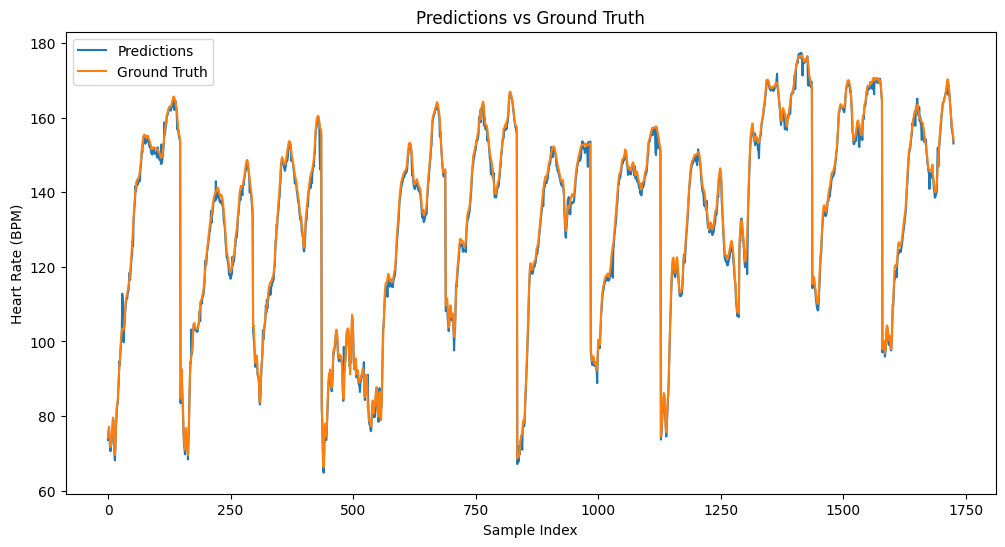

In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X, y, batch_size=batch_size, verbose=0)
print("Test MAE:", test_mae)

# Make predictions
predictions = model.predict(X)
total_mae = np.mean(np.abs(predictions - y))

# Plot predictions vs ground truth
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predictions')
plt.plot(y, label='Ground Truth')
plt.title('Predictions vs Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate (BPM)')
plt.legend()
plt.show()

print("Total MAE:", total_mae)

### Evaluate the Model

We will evaluate the trained model on the test dataset and visualize the predictions compared to the ground truth.


In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("Test MAE:", test_mae)

# Make predictions
predictions = model.predict(x_test)
total_mae = np.mean(np.abs(predictions - y_test))

# Plot predictions vs ground truth
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predictions')
plt.plot(y_test, label='Ground Truth')
plt.title('Predictions vs Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate (BPM)')
plt.legend()
plt.show()

print("Total MAE:", total_mae)

### Analyze Model Performance

In this section, we will analyze the model performance by calculating and plotting the error distribution.


In [ ]:
# Calculate absolute errors
errors = np.abs(predictions.flatten() - y_test.flatten())

# Plot error distribution
plt.figure(figsize=(12, 4))
plt.hist(errors, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Absolute Error (BPM)')
plt.ylabel('Frequency')
plt.show()

# Print mean and standard deviation of errors
mean_error = np.mean(errors)
std_error = np.std(errors)
print("Mean Absolute Error:", mean_error)
print("Standard Deviation of Error:", std_error)
